This notebook trains a VAE with a 3-dimensional latent space on the yield curve data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
from sklearn.decomposition import PCA
from plotting_utils import plot_marginal_r_squares
from data_utils import load_yield_data, load_fred_md
from seed_utils import set_random_seed
from plotting_utils import plot_latent_space_trajectory_3d_static

from VanillaVAE import VanillaVAE1D
set_random_seed(1)

yield_data = load_yield_data()
FIRST_DATE = yield_data.index.min() - pd.DateOffset(months=1)
LAST_DATE = yield_data.index.max()

# Model and training loop

In [2]:
def analyticalPCA(y, dimension):
    pca = PCA(n_components=dimension)
    pca.fit(y)
    return pca.components_, pca.transform(y)

# Prepare data
y = yield_data.values.astype('float32')
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
y_normalized = (y - y_mean) / y_std

# Convert to PyTorch tensors
# Shape: (n_samples, 1, 120) - add channel dimension for Conv1D
y_tensor = torch.FloatTensor(y_normalized).unsqueeze(1)

# Create DataLoader
batch_size = 32
dataset = TensorDataset(y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Using device: {device}")

vae = VanillaVAE1D(
    in_channels=1,
    seq_length=120,
    latent_dim=3,
    hidden_dims=[32, 64, 128]
).to(device)

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training parameters
kld_weight = 0.00025  # Beta parameter (lower = less regularization)

# --- ANNEALING PARAMETERS ---
num_epochs = 50
# 1. Warm-up Phase: KLD weight is 0 for the first 10 epochs.
anneal_start_epoch = 10
# 2. Annealing Phase: KLD weight linearly increases over the next 20 epochs.
anneal_duration = 20
# 3. Final Phase: KLD weight stays at its final value for the rest of training.
start_beta = 0.0
end_beta = 0.0025

# Storage for losses
train_losses = {
    'total': [],
    'reconstruction': [],
    'kld': []
}

Using device: cuda


In [ ]:
# Training loop
for epoch in range(num_epochs):
    vae.train()
    epoch_losses = {
        'total': 0.0,
        'reconstruction': 0.0,
        'kld': 0.0
    }
    
    # --- DYNAMIC KLD WEIGHT CALCULATION ---
    if epoch < anneal_start_epoch:
        kld_weight = start_beta
    elif epoch < anneal_start_epoch + anneal_duration:
        progress = (epoch - anneal_start_epoch) / anneal_duration
        kld_weight = start_beta + (end_beta - start_beta) * progress
    else:
        kld_weight = end_beta
    # ---------------------------------------    

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data,) in enumerate(pbar):
        data = data.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        recons, input, mu, log_var = vae(data)
        
        # Calculate loss
        loss_dict = vae.loss_function(
            recons, input, mu, log_var,
            kld_weight=kld_weight
        )
        
        # Backward pass
        loss = loss_dict['loss']
        loss.backward()
                
        # Update weights
        optimizer.step()
        
        # Accumulate losses
        epoch_losses['total'] += loss.item()
        epoch_losses['reconstruction'] += loss_dict['Reconstruction_Loss'].item()
        epoch_losses['kld'] += loss_dict['KLD'].item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'recon': f"{loss_dict['Reconstruction_Loss'].item():.4f}",
            'kld': f"{loss_dict['KLD'].item():.4f}"
        })
    
    # Average losses for epoch
    num_batches = len(train_loader)
    epoch_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    
    # Store losses
    train_losses['total'].append(epoch_losses['total'])
    train_losses['reconstruction'].append(epoch_losses['reconstruction'])
    train_losses['kld'].append(epoch_losses['kld'])
    
    # Print epoch summary
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Total Loss: {epoch_losses['total']:.4f}")
        print(f"  Reconstruction: {epoch_losses['reconstruction']:.4f}")
        print(f"  KLD: {epoch_losses['kld']:.4f}")
        print("-"*60)

# Training loss

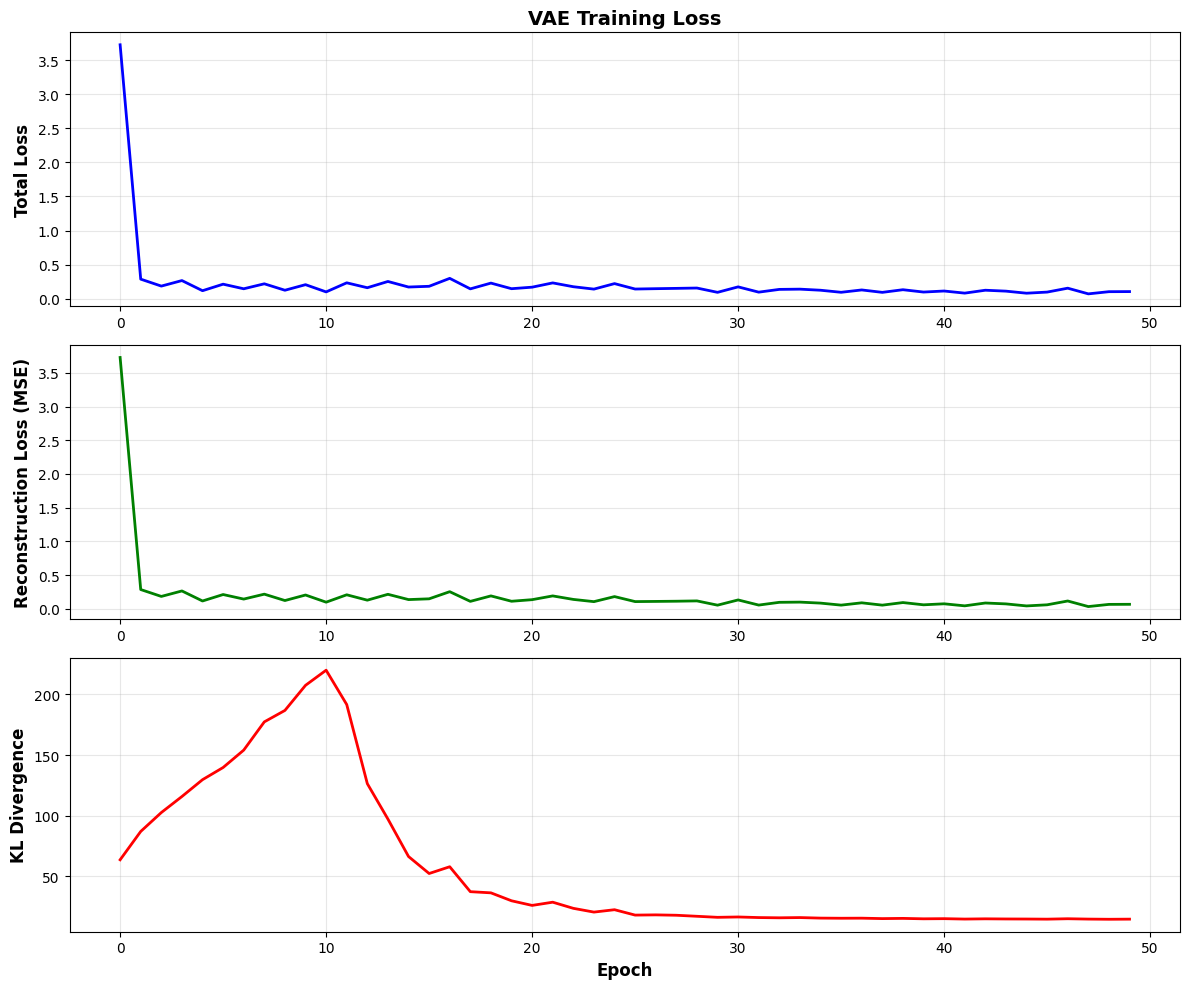


Final Training Metrics:
Total Loss: 0.103807
Reconstruction Loss: 0.067625


In [4]:
# Plot training losses
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Total loss
axes[0].plot(train_losses['total'], linewidth=2, color='blue')
axes[0].set_ylabel('Total Loss', fontsize=12, fontweight='bold')
axes[0].set_title('VAE Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(train_losses['reconstruction'], linewidth=2, color='green')
axes[1].set_ylabel('Reconstruction Loss (MSE)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KLD loss
axes[2].plot(train_losses['kld'], linewidth=2, color='red')
axes[2].set_ylabel('KL Divergence', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Total Loss: {train_losses['total'][-1]:.6f}")
print(f"Reconstruction Loss: {train_losses['reconstruction'][-1]:.6f}")

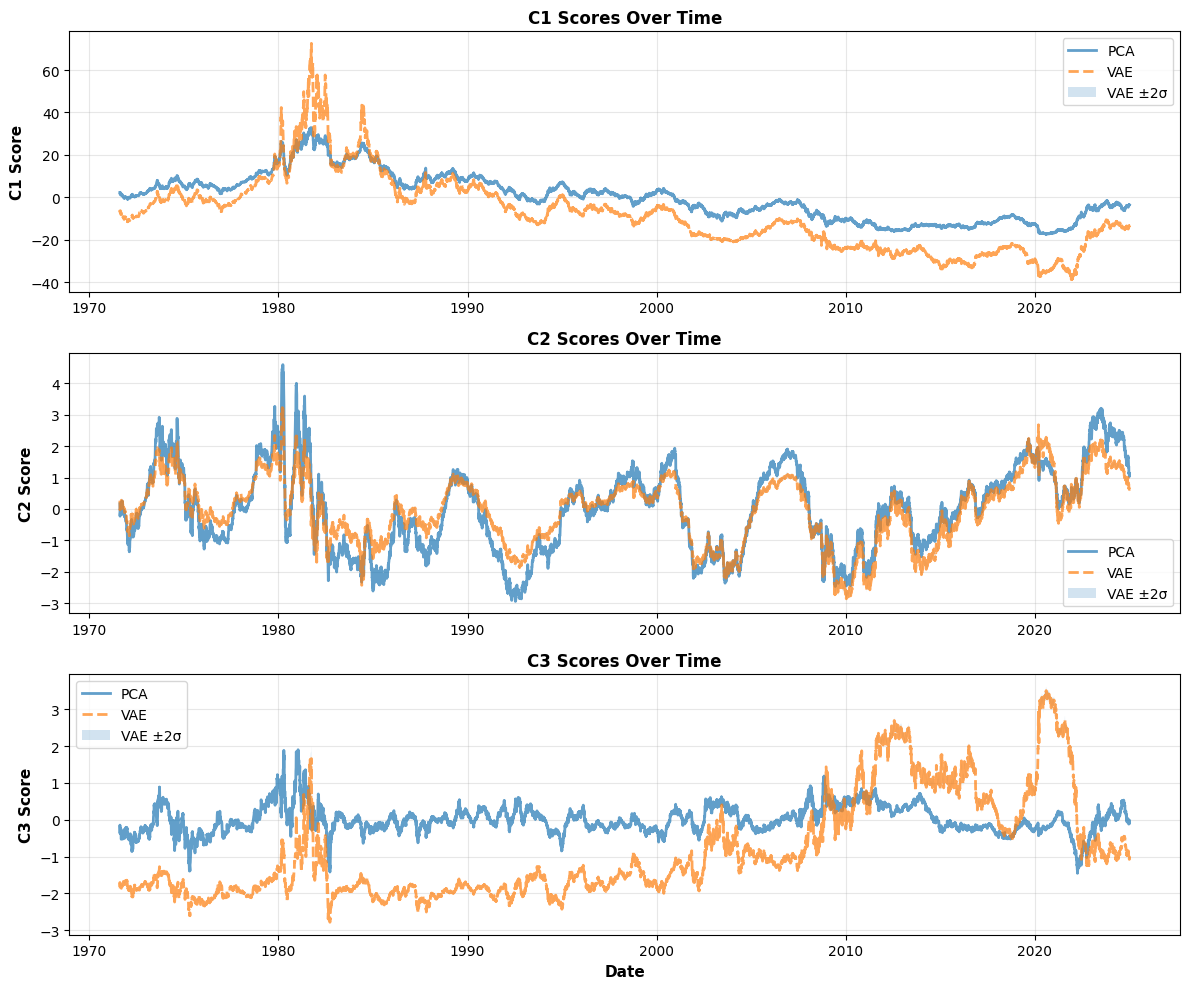

In [5]:
# Extract latent factors from VAE
vae.eval()
with torch.no_grad():
    y_tensor_full = torch.FloatTensor(y_normalized).unsqueeze(1).to(device)
    mu, log_var = vae.encode(y_tensor_full)
    
    vae_scores = mu.cpu().numpy()
    vae_std = torch.exp(0.5 * log_var).cpu().numpy()

vae_scores_df = pd.DataFrame(
    vae_scores,
    index=yield_data.index,
    columns=['C3', 'C2', 'C1']
)

# Write VAE scores to csv
vae_scores_df.to_csv(r'scores/vae_scores.csv')

# Calculate PCA for comparison
p_analytical, pca_scores = analyticalPCA(y_normalized, dimension=3)
pca_scores_df = pd.DataFrame(
    pca_scores,
    index=yield_data.index,
    columns=['C1', 'C2', 'C3']
)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
# for i, comp in enumerate(['C1', 'C2', 'C3']):
for i, comp in enumerate(['C1', 'C2', 'C3']):
    # multiply by 10 to scale C1 for better visualization
    vae_scores_df['C1'] *= 10

    axes[i].plot(pca_scores_df.index, pca_scores_df[comp], 
                 label='PCA', alpha=0.7, linewidth=2)
    axes[i].plot(vae_scores_df.index, vae_scores_df[comp], 
                 label='VAE', alpha=0.7, linewidth=2, linestyle='--')
    
    # Add uncertainty bands for VAE
    axes[i].fill_between(
        vae_scores_df.index,
        vae_scores_df[comp] - 2*vae_std[:, i],
        vae_scores_df[comp] + 2*vae_std[:, i],
        alpha=0.2,
        label='VAE ±2σ'
    )
    
    axes[i].set_ylabel(f'{comp} Score', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{comp} Scores Over Time', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel('Date', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

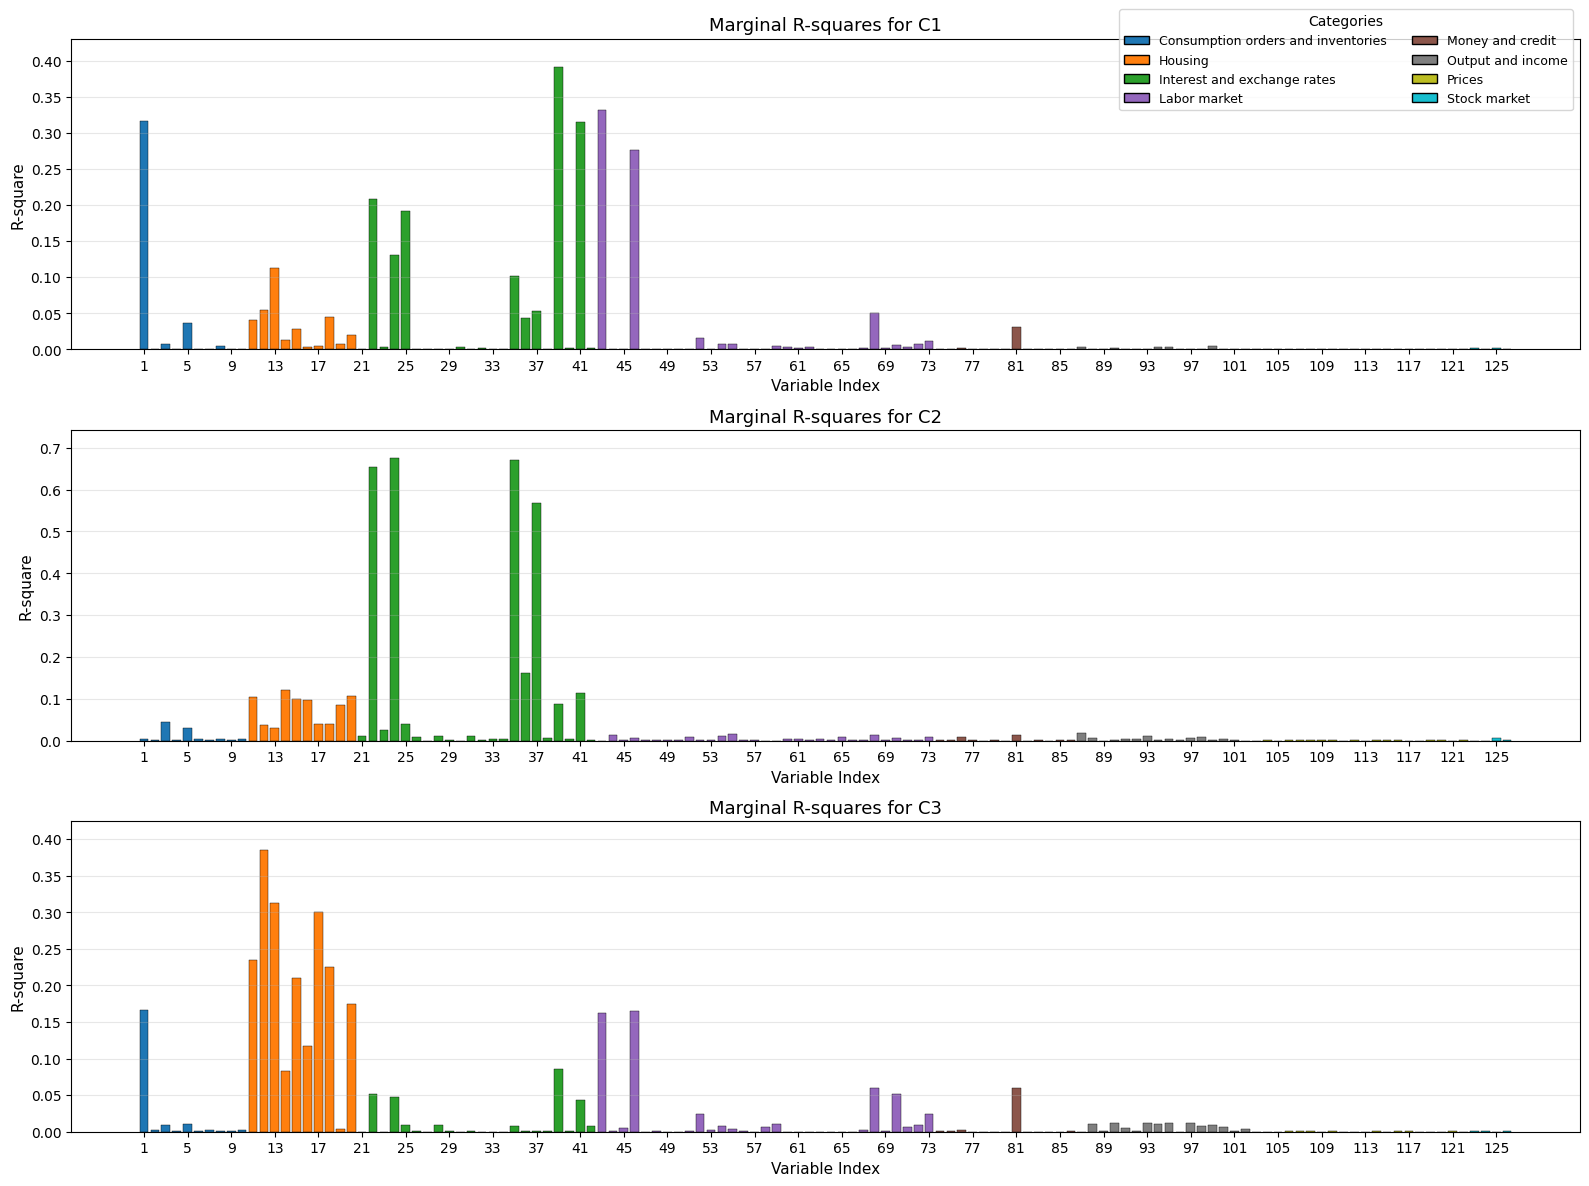

In [6]:
# Resample to monthly
vae_scores_monthly = vae_scores_df.resample('MS').first()
fred_md = load_fred_md(FIRST_DATE, LAST_DATE)

plot_marginal_r_squares(fred_md, vae_scores_monthly)

# Reconstruction quality

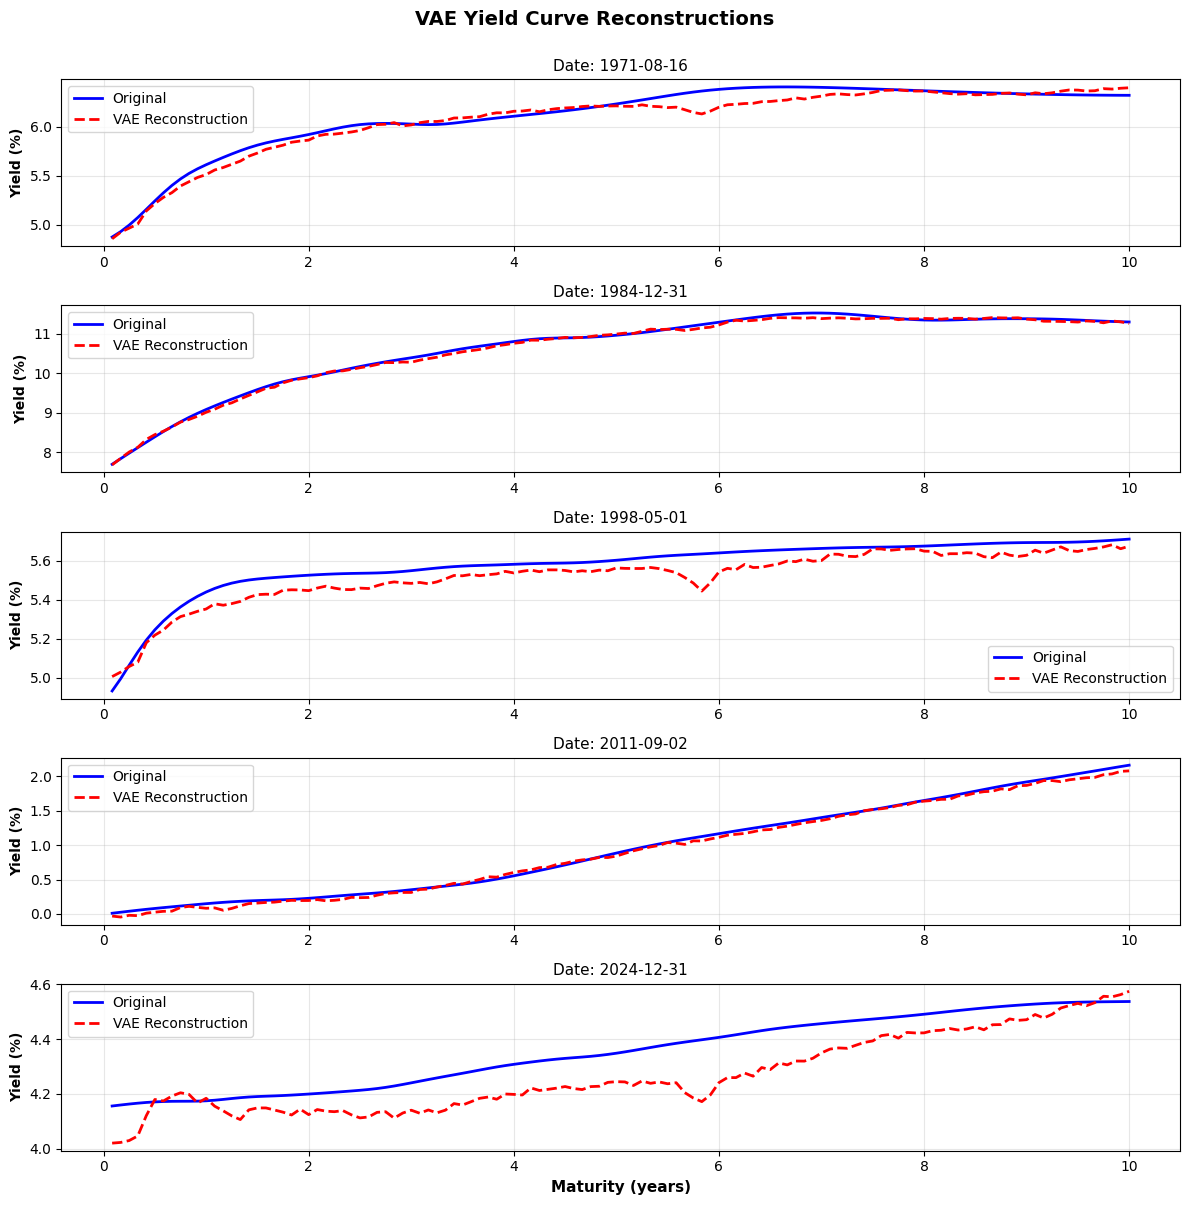

In [7]:
# Reconstruct yield curves
vae.eval()
with torch.no_grad():
    recons, _, _, _ = vae(y_tensor_full)
    recons = recons.cpu().numpy().squeeze()

# Denormalize
recons_denorm = recons * y_std + y_mean
y_original = y

# Plot some reconstructions
n_examples = 5
indices = np.linspace(0, len(y)-1, n_examples, dtype=int)

maturities_years = np.arange(1, 121) / 12

fig, axes = plt.subplots(n_examples, 1, figsize=(12, 12))

for idx, ax in zip(indices, axes):
    date = yield_data.index[idx]
    ax.plot(maturities_years, y_original[idx], 'b-', linewidth=2, label='Original')
    ax.plot(maturities_years, recons_denorm[idx], 'r--', linewidth=2, label='VAE Reconstruction')
    ax.set_ylabel('Yield (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Date: {date.strftime("%Y-%m-%d")}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Maturity (years)', fontsize=11, fontweight='bold')
plt.suptitle('VAE Yield Curve Reconstructions', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Latent space trajectories:

The plots show that the autoencoder has learned a more structured data manifold whereas PCA infers a more diffuse cloud.

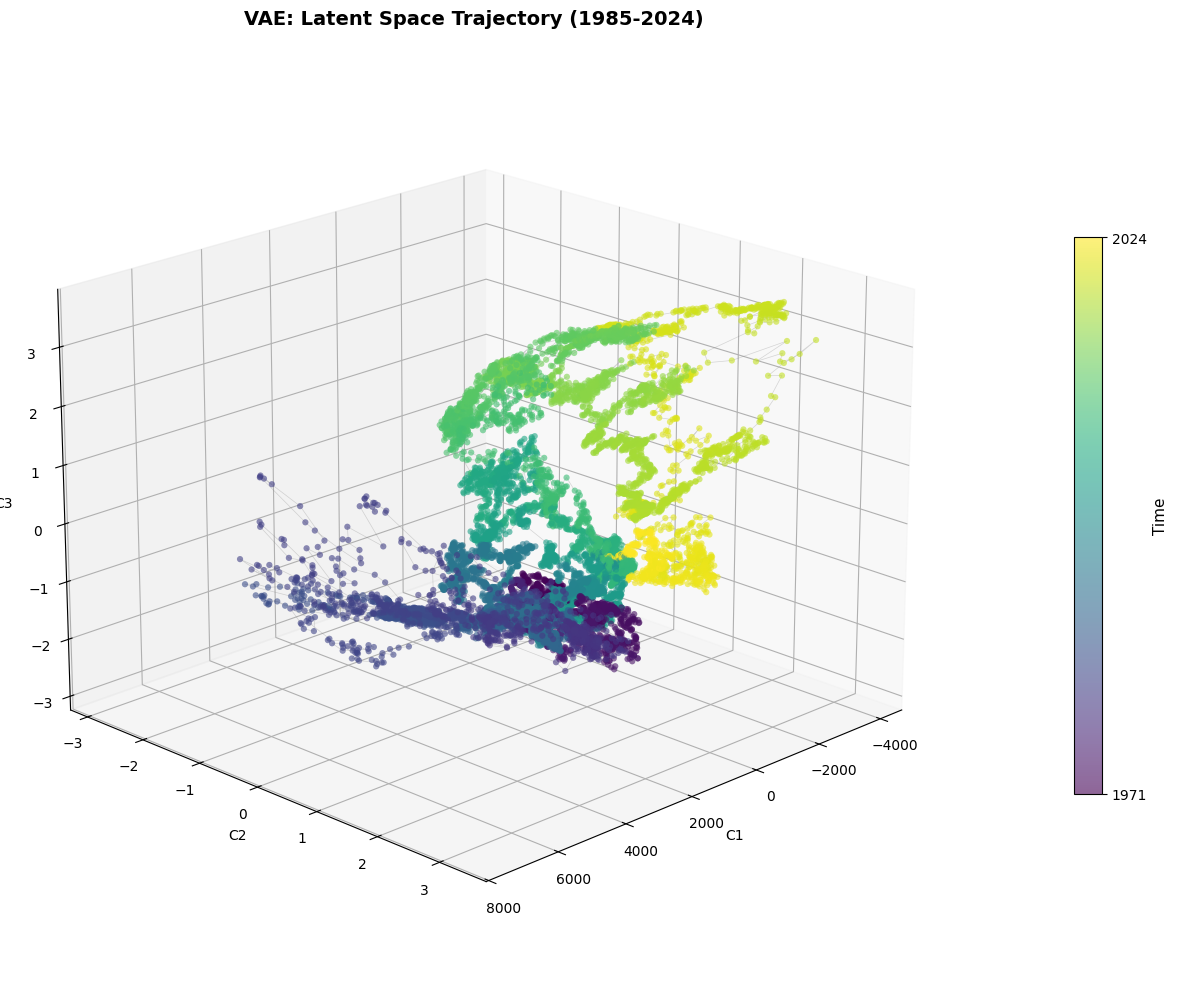

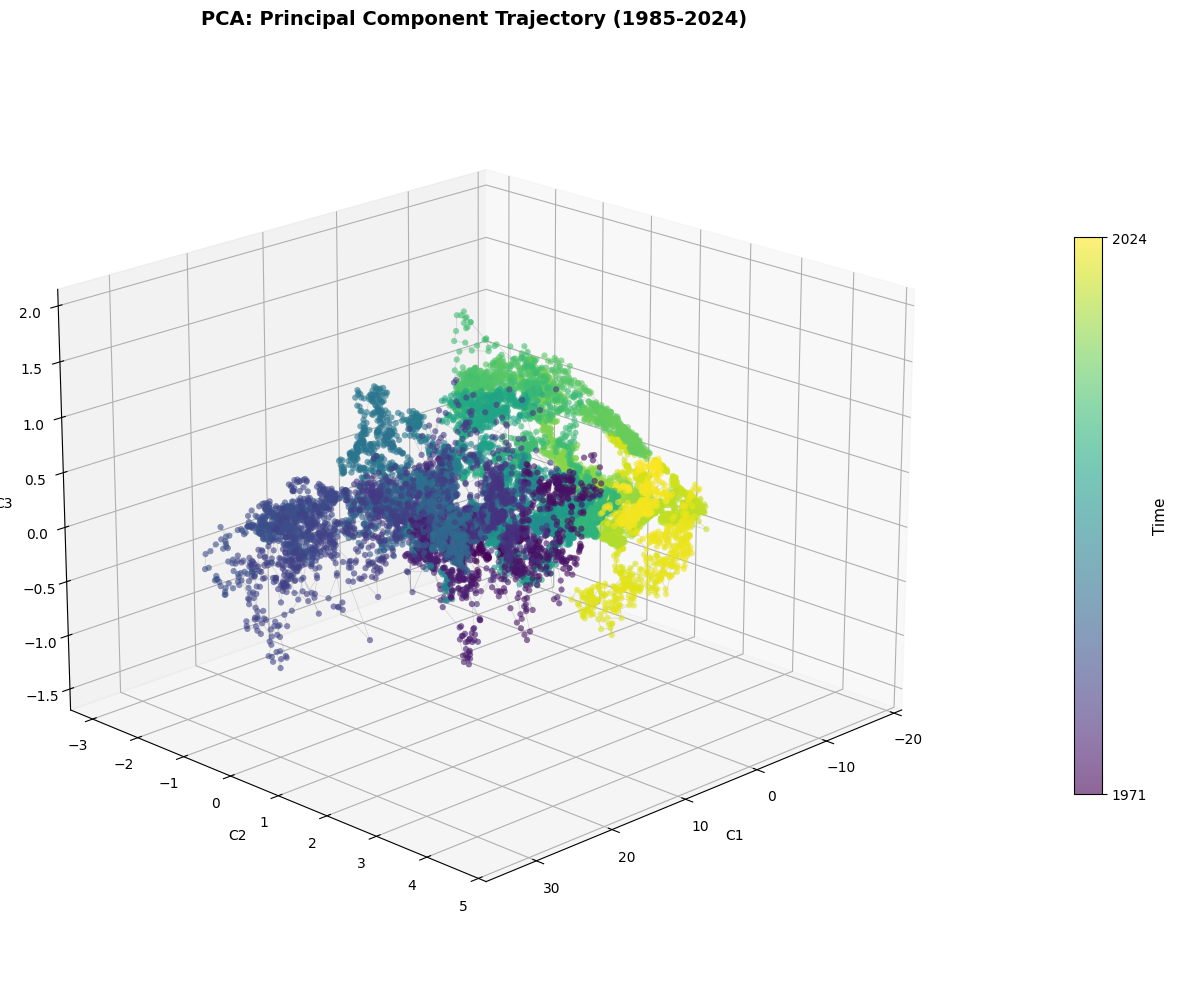

In [8]:
fig_static_deep = plot_latent_space_trajectory_3d_static(
    vae_scores_df,
    title="VAE: Latent Space Trajectory (1985-2024)"
)
plt.show()

fig_static_pca = plot_latent_space_trajectory_3d_static(
    pca_scores_df,
    title="PCA: Principal Component Trajectory (1985-2024)"
)
plt.show()

ChatGPT/Gemini-generated latent space visualizations:

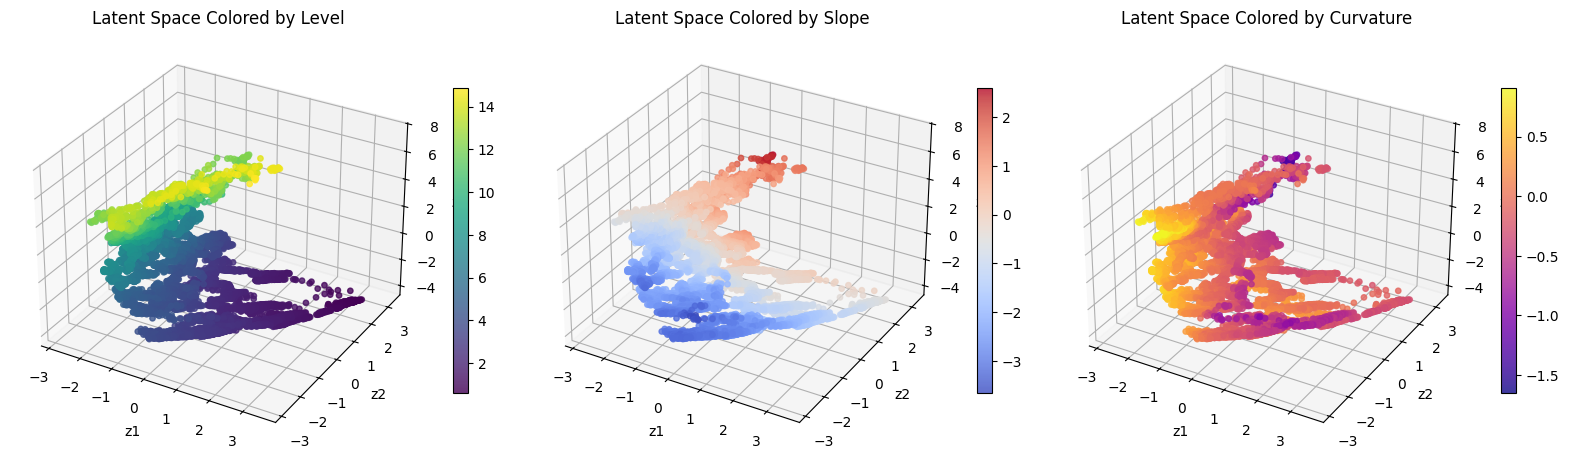

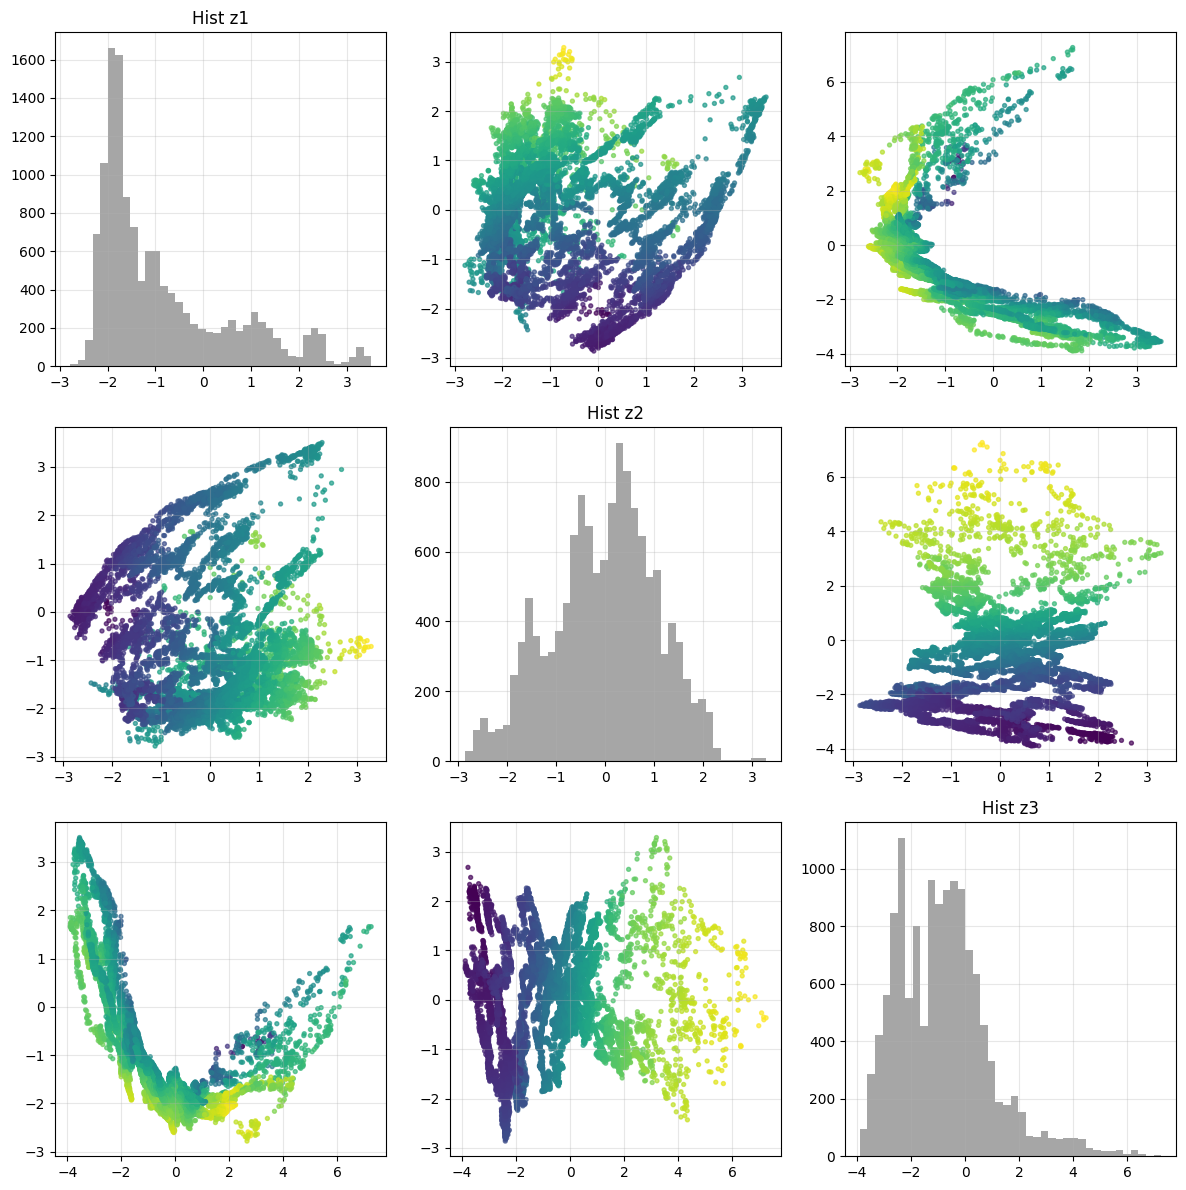

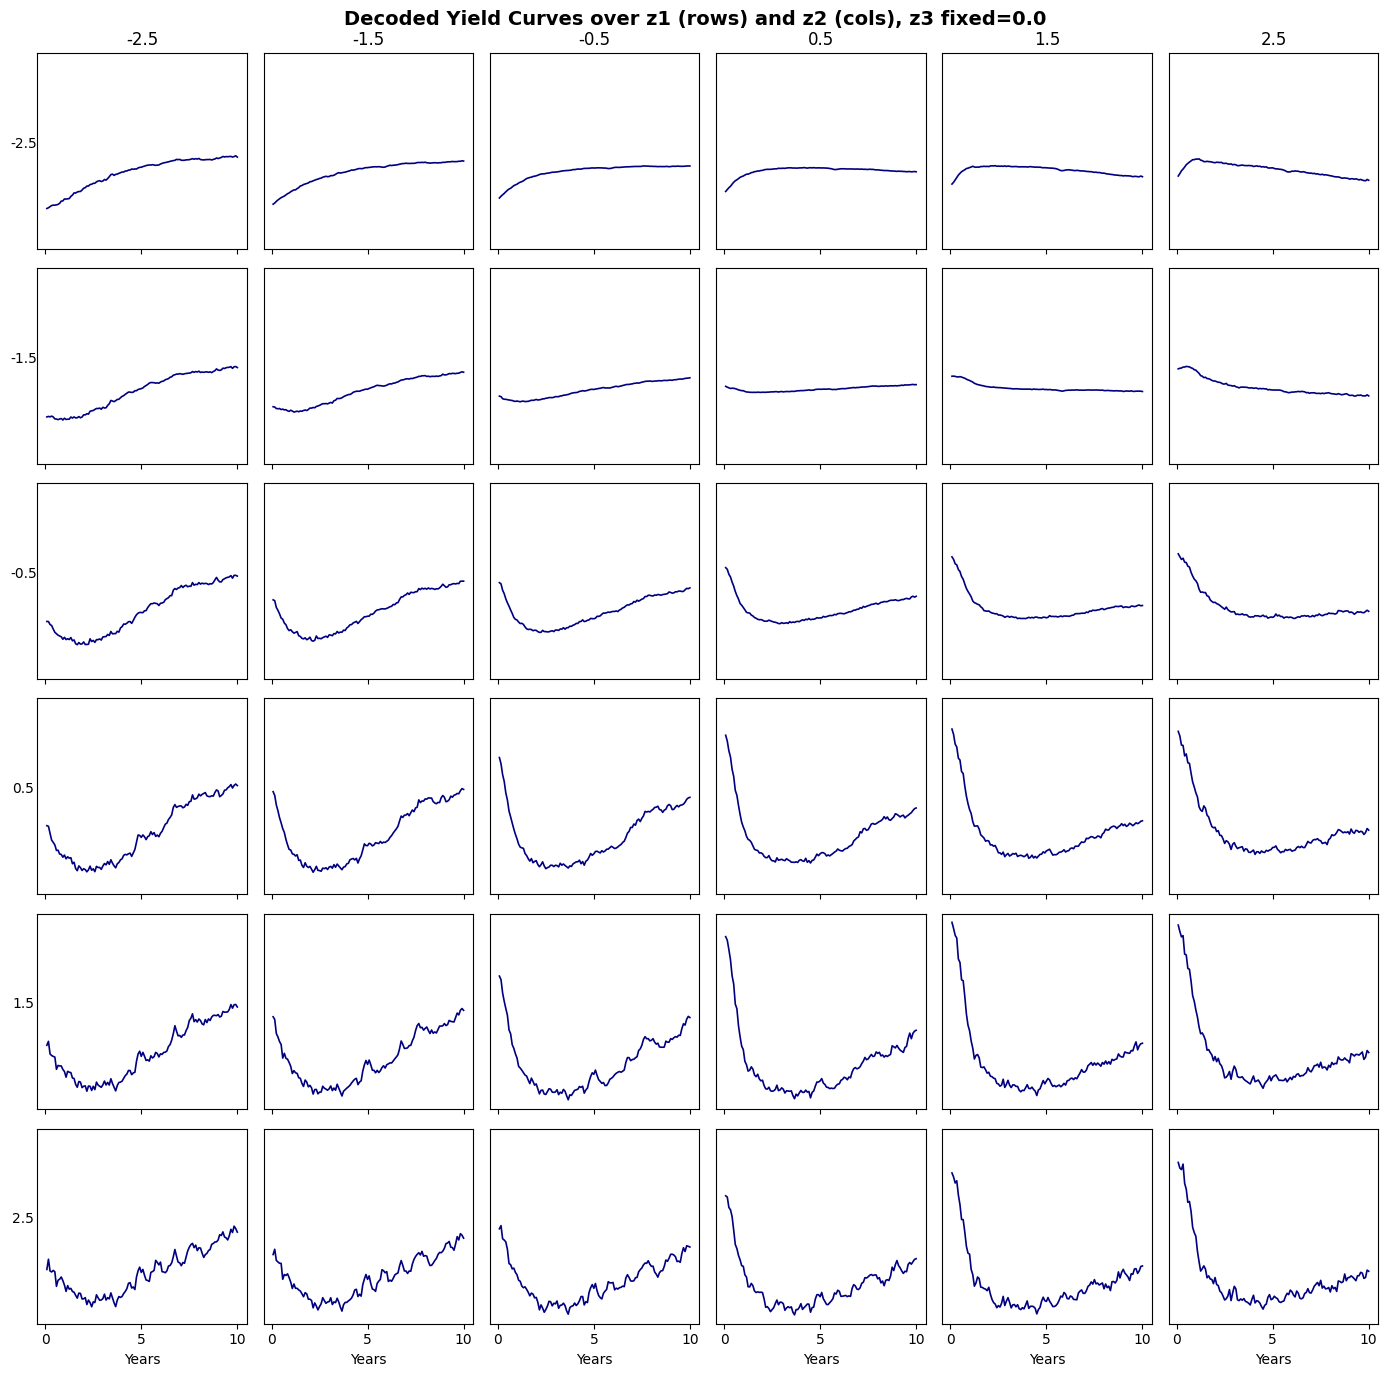

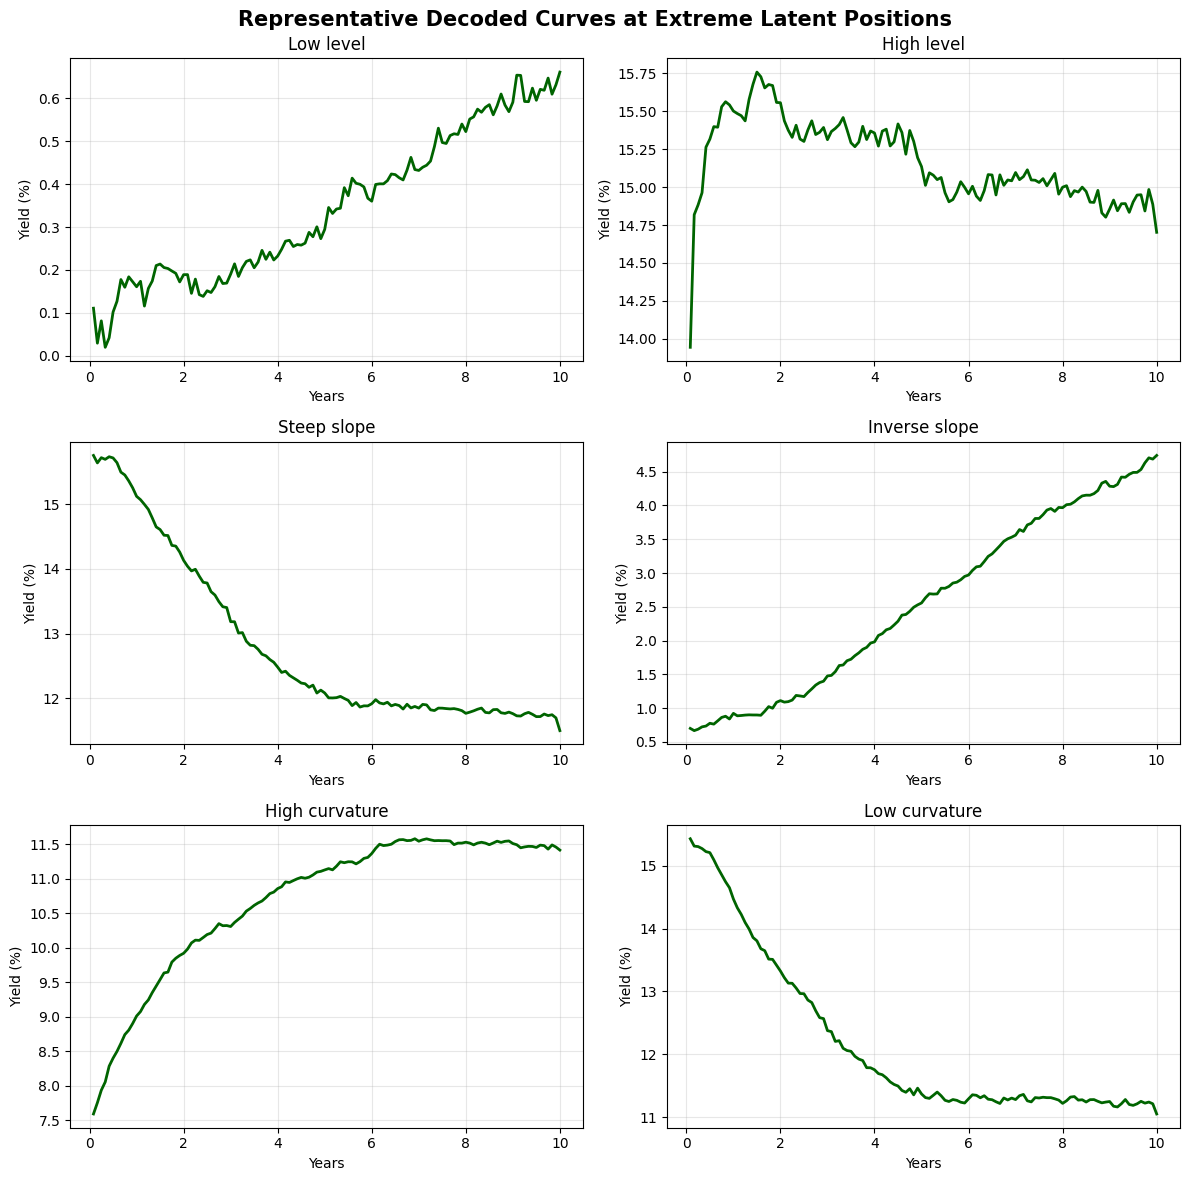

In [9]:
# ========= LATENT SPACE UTILITIES =========
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def compute_curve_features(curves_denorm: np.ndarray):
    """
    Compute simple level / slope / curvature features for each yield curve.
    level  : average of long maturities (e.g. last 24 months ~ years 8-10)
    slope  : y2y - y10y  (12m*2 vs 120m) -> using y at 24m and 120m
    curvature : 2*y5y - y2y - y10y  (using 60m, 24m, 120m)
    """
    # indices (0-based) for specific maturities
    idx_24m  = 24 - 1
    idx_60m  = 60 - 1
    idx_120m = 120 - 1
    # long tail average: last 24 maturities (months 97-120)
    level = curves_denorm[:, -24:].mean(axis=1)
    slope = curves_denorm[:, idx_24m] - curves_denorm[:, idx_120m]
    curvature = 2*curves_denorm[:, idx_60m] - curves_denorm[:, idx_24m] - curves_denorm[:, idx_120m]
    return level, slope, curvature

# Get latent embeddings (mu) and associated decoded curves
vae.eval()
with torch.no_grad():
    mu, log_var = vae.encode(y_tensor_full.to(device))
    z_mean = mu.cpu().numpy()
    recons_all, _, _, _ = vae(y_tensor_full.to(device))
    recons_all = recons_all.cpu().numpy().squeeze()
    recons_denorm_all = recons_all * y_std + y_mean

level, slope, curvature = compute_curve_features(recons_denorm_all)

latent_df = pd.DataFrame(
    z_mean,
    index=yield_data.index,
    columns=[f"z{i+1}" for i in range(z_mean.shape[1])]
)
latent_df['level'] = level
latent_df['slope'] = slope
latent_df['curvature'] = curvature

# ========= 3D SCATTER COLORED BY FEATURES =========
fig = plt.figure(figsize=(16,5))
for i,(feat, cmap) in enumerate([('level','viridis'),('slope','coolwarm'),('curvature','plasma')]):
    ax = fig.add_subplot(1,3,i+1, projection='3d')
    sc = ax.scatter(latent_df['z1'], latent_df['z2'], latent_df['z3'],
                    c=latent_df[feat], cmap=cmap, s=15, alpha=0.8)
    ax.set_title(f"Latent Space Colored by {feat.capitalize()}")
    ax.set_xlabel('z1'); ax.set_ylabel('z2'); ax.set_zlabel('z3')
    fig.colorbar(sc, ax=ax, shrink=0.65, pad=0.05)
plt.tight_layout()
plt.show()

# ========= 2D PAIR SCATTERS =========
pair_feats = ['level','slope','curvature']
fig, axes = plt.subplots(3,3, figsize=(12,12))
for r in range(3):
    for c in range(3):
        ax = axes[r,c]
        if r == c:
            ax.hist(latent_df[f'z{r+1}'], bins=40, color='gray', alpha=0.7)
            ax.set_title(f"Hist z{r+1}")
        else:
            sc = ax.scatter(latent_df[f'z{r+1}'], latent_df[f'z{c+1}'],
                            c=latent_df[pair_feats[(r+c)%3]], cmap='viridis', s=8, alpha=0.7)
        ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ========= GRID SAMPLING (2D SLICE) =========
def sample_latent_grid(vae, fixed_dim=3, fixed_value=0.0, n_steps=7, span=2.5):
    """
    Create a grid over two latent dimensions (others fixed) and decode curves.
    fixed_dim: which latent coordinate (1-indexed) to hold constant.
    fixed_value: value to keep that coordinate at.
    n_steps: number of grid points per axis.
    span: range (+/- span) in latent space for the two varying dims.
    """
    lat_dim = vae.latent_dim
    dims = [d for d in range(lat_dim) if d != (fixed_dim-1)]
    a_dim, b_dim = dims[0], dims[1]
    a_values = np.linspace(-span, span, n_steps)
    b_values = np.linspace(-span, span, n_steps)
    curves = []
    coords = []
    for a in a_values:
        row_curves = []
        row_coords = []
        for b in b_values:
            z = torch.zeros(1, lat_dim, device=device)
            z[0, fixed_dim-1] = fixed_value
            z[0, a_dim] = torch.tensor(a, device=device)
            z[0, b_dim] = torch.tensor(b, device=device)
            with torch.no_grad():
                decoded = vae.decode(z).cpu().numpy().squeeze()
            decoded_denorm = decoded * y_std + y_mean
            row_curves.append(decoded_denorm)
            row_coords.append((a,b))
        curves.append(row_curves)
        coords.append(row_coords)
    return np.array(curves), (a_values, b_values), (a_dim+1, b_dim+1)

grid_curves, (a_vals,b_vals), (a_label,b_label) = sample_latent_grid(
    vae, fixed_dim=3, fixed_value=0.0, n_steps=6, span=2.5
)

# Plot as small multiples
fig, axes = plt.subplots(grid_curves.shape[0], grid_curves.shape[1],
                         figsize=(14,14), sharex=True, sharey=True)
maturities_years = np.arange(1, 121)/12
for i in range(grid_curves.shape[0]):
    for j in range(grid_curves.shape[1]):
        ax = axes[i,j]
        ax.plot(maturities_years, grid_curves[i,j], color='navy', linewidth=1.2)
        ax.set_xticks([0,5,10])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f"{b_vals[j]:.1f}")
        if j == 0:
            ax.set_ylabel(f"{a_vals[i]:.1f}", rotation=0, labelpad=10)
for ax in axes[-1,:]:
    ax.set_xlabel("Years")
fig.suptitle(f"Decoded Yield Curves over z{a_label} (rows) and z{b_label} (cols), z3 fixed=0.0",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ========= EXTREME POINT COMPARISON =========
ext_points = {
    'Low level': latent_df.nsmallest(1,'level').iloc[0][['z1','z2','z3']].values,
    'High level': latent_df.nlargest(1,'level').iloc[0][['z1','z2','z3']].values,
    'Steep slope': latent_df.nlargest(1,'slope').iloc[0][['z1','z2','z3']].values,
    'Inverse slope': latent_df.nsmallest(1,'slope').iloc[0][['z1','z2','z3']].values,
    'High curvature': latent_df.nlargest(1,'curvature').iloc[0][['z1','z2','z3']].values,
    'Low curvature': latent_df.nsmallest(1,'curvature').iloc[0][['z1','z2','z3']].values,
}

fig, axes = plt.subplots(3,2, figsize=(12,12))
axes = axes.flatten()
for ax, (label, point) in zip(axes, ext_points.items()):
    z = torch.tensor(point, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        dec = vae.decode(z).cpu().numpy().squeeze()
    dec_denorm = dec * y_std + y_mean
    ax.plot(maturities_years, dec_denorm, color='darkgreen', linewidth=2)
    ax.set_title(label)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Years"); ax.set_ylabel("Yield (%)")
plt.suptitle("Representative Decoded Curves at Extreme Latent Positions", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()